# ch06/optimizer_compare_naive.py

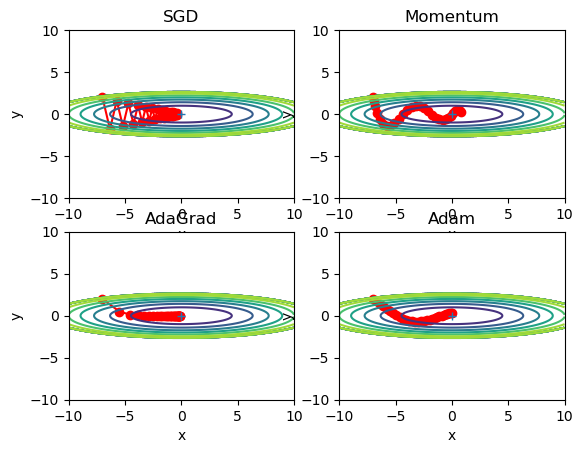

In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

# ch06/optimizer_compare_mnist.py

===========iteration:0===========
SGD:2.408242718249455
Momentum:2.4068394349139055
AdaGrad:2.399048853500868
Adam:2.1944214827730084
===========iteration:100===========
SGD:1.4838006036312186
Momentum:0.42186019265352653
AdaGrad:0.1908289162678628
Adam:0.3378542776491954
===========iteration:200===========
SGD:0.6389040136786772
Momentum:0.16794397652275167
AdaGrad:0.08875720456184207
Adam:0.12348264009510228
===========iteration:300===========
SGD:0.46480378235552966
Momentum:0.14420780552466841
AdaGrad:0.07464379771654434
Adam:0.10528838920196336
===========iteration:400===========
SGD:0.39548868057941255
Momentum:0.13572647486759665
AdaGrad:0.0697300630156496
Adam:0.1405630630811324
===========iteration:500===========
SGD:0.28667939371789586
Momentum:0.12319715144353018
AdaGrad:0.04046594711361991
Adam:0.07378898604506837
===========iteration:600===========
SGD:0.4203787432917502
Momentum:0.21723350800065033
AdaGrad:0.11933290725927105
Adam:0.14664824336555854
===========iteration:

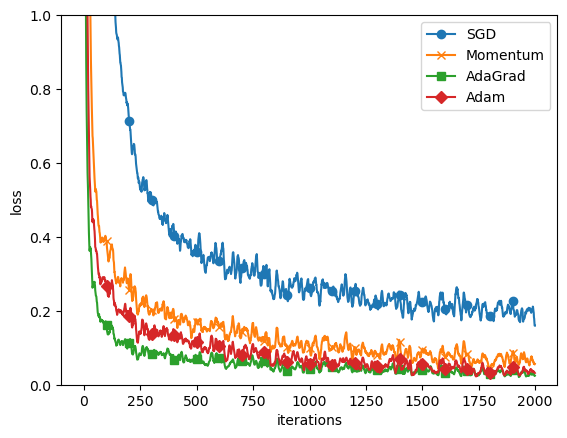

In [2]:
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()


# ch06/weight_init_activation_histogram.py

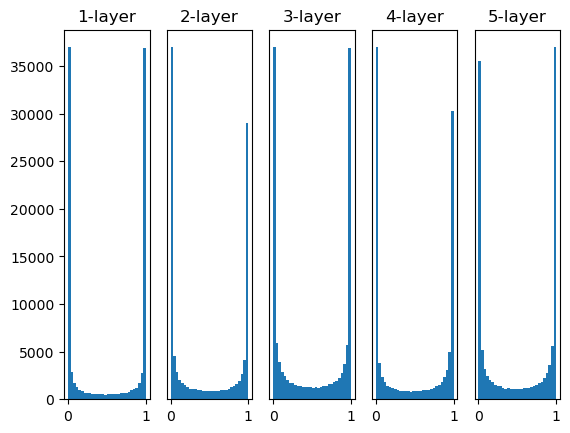

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


# ch06/weight_init_compare.py

===========iteration:0===========
std=0.01:2.3025157956274507
Xavier:2.3020734893031785
He:2.4544075041920133
===========iteration:100===========
std=0.01:2.302178072880435
Xavier:2.2321235770179886
He:1.5613527786505133
===========iteration:200===========
std=0.01:2.303043613078236
Xavier:2.093645801413508
He:0.842903460666329
===========iteration:300===========
std=0.01:2.3004026014519234
Xavier:1.9030425166471616
He:0.532314643590287
===========iteration:400===========
std=0.01:2.3034116818307107
Xavier:1.56656187320357
He:0.5057243829319312
===========iteration:500===========
std=0.01:2.301104689616488
Xavier:1.06381099382007
He:0.3409061411273618
===========iteration:600===========
std=0.01:2.3008604448121255
Xavier:0.7205375193206949
He:0.36962253123804845
===========iteration:700===========
std=0.01:2.299281852690279
Xavier:0.5682012162189156
He:0.23922734532605736
===========iteration:800===========
std=0.01:2.300877042213036
Xavier:0.4956058039394971
He:0.34717193249557177
===

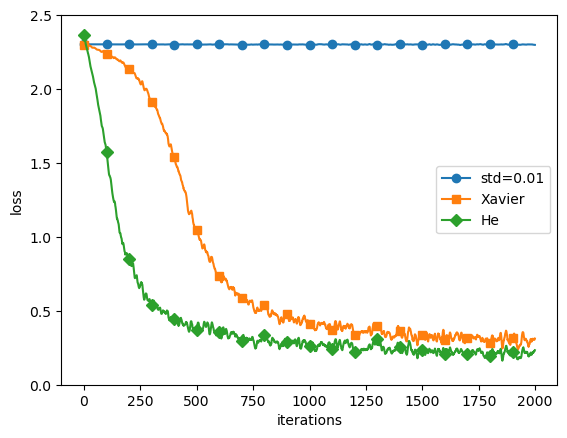

In [4]:
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

# ch06/batch_norm_gradient_check.py

In [5]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100], output_size=10,
                              use_batchnorm=True)

x_batch = x_train[:1]
t_batch = t_train[:1]

grad_backprop = network.gradient(x_batch, t_batch)
grad_numerical = network.numerical_gradient(x_batch, t_batch)


for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:0.0
b1:0.0
gamma1:0.0
beta1:0.0
W2:0.0
b2:0.0
gamma2:0.0
beta2:0.05629097639991976
W3:0.0
b3:1.7990357854824612e-07


# ch06/batch_norm_test.py

============== 1/16 ==============
epoch:0 | 0.093 - 0.102


/home/studio-lab-user/deep-learning-from-scratch/notebooks/../common/multi_layer_net_extend.py:101: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/home/studio-lab-user/deep-learning-from-scratch/notebooks/../common/multi_layer_net_extend.py:101: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.124
epoch:2 | 0.097 - 0.147
epoch:3 | 0.097 - 0.173
epoch:4 | 0.097 - 0.182
epoch:5 | 0.097 - 0.207
epoch:6 | 0.097 - 0.228
epoch:7 | 0.097 - 0.258
epoch:8 | 0.097 - 0.272
epoch:9 | 0.097 - 0.289
epoch:10 | 0.097 - 0.295
epoch:11 | 0.097 - 0.317
epoch:12 | 0.097 - 0.333
epoch:13 | 0.097 - 0.337
epoch:14 | 0.097 - 0.356
epoch:15 | 0.097 - 0.363
epoch:16 | 0.097 - 0.384
epoch:17 | 0.097 - 0.395
epoch:18 | 0.097 - 0.403


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.097 - 0.419
============== 2/16 ==============
epoch:0 | 0.087 - 0.092


/home/studio-lab-user/deep-learning-from-scratch/notebooks/../common/functions.py:32: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策


epoch:1 | 0.097 - 0.121
epoch:2 | 0.097 - 0.166
epoch:3 | 0.097 - 0.199
epoch:4 | 0.097 - 0.228
epoch:5 | 0.097 - 0.262
epoch:6 | 0.097 - 0.297
epoch:7 | 0.097 - 0.307
epoch:8 | 0.097 - 0.326
epoch:9 | 0.097 - 0.348
epoch:10 | 0.097 - 0.368
epoch:11 | 0.097 - 0.378
epoch:12 | 0.097 - 0.398
epoch:13 | 0.097 - 0.424
epoch:14 | 0.097 - 0.418
epoch:15 | 0.097 - 0.44
epoch:16 | 0.097 - 0.45
epoch:17 | 0.097 - 0.468
epoch:18 | 0.097 - 0.485


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.097 - 0.498
============== 3/16 ==============
epoch:0 | 0.138 - 0.108
epoch:1 | 0.385 - 0.095
epoch:2 | 0.504 - 0.129
epoch:3 | 0.591 - 0.147
epoch:4 | 0.647 - 0.192
epoch:5 | 0.727 - 0.229
epoch:6 | 0.761 - 0.274
epoch:7 | 0.799 - 0.314
epoch:8 | 0.84 - 0.359
epoch:9 | 0.883 - 0.4
epoch:10 | 0.908 - 0.418
epoch:11 | 0.931 - 0.451
epoch:12 | 0.942 - 0.462
epoch:13 | 0.946 - 0.495
epoch:14 | 0.952 - 0.525
epoch:15 | 0.964 - 0.546
epoch:16 | 0.966 - 0.574
epoch:17 | 0.972 - 0.593
epoch:18 | 0.978 - 0.614


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.979 - 0.63
============== 4/16 ==============
epoch:0 | 0.126 - 0.074
epoch:1 | 0.233 - 0.086
epoch:2 | 0.352 - 0.148
epoch:3 | 0.441 - 0.207
epoch:4 | 0.508 - 0.282
epoch:5 | 0.574 - 0.359
epoch:6 | 0.617 - 0.409
epoch:7 | 0.652 - 0.46
epoch:8 | 0.68 - 0.506
epoch:9 | 0.694 - 0.553
epoch:10 | 0.715 - 0.584
epoch:11 | 0.742 - 0.621
epoch:12 | 0.752 - 0.646
epoch:13 | 0.765 - 0.672
epoch:14 | 0.777 - 0.69
epoch:15 | 0.785 - 0.7
epoch:16 | 0.793 - 0.728
epoch:17 | 0.803 - 0.736
epoch:18 | 0.818 - 0.752


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.823 - 0.763
============== 5/16 ==============
epoch:0 | 0.13 - 0.098
epoch:1 | 0.14 - 0.155
epoch:2 | 0.145 - 0.309
epoch:3 | 0.147 - 0.461
epoch:4 | 0.16 - 0.546
epoch:5 | 0.172 - 0.608
epoch:6 | 0.182 - 0.657
epoch:7 | 0.186 - 0.689
epoch:8 | 0.205 - 0.724
epoch:9 | 0.203 - 0.75
epoch:10 | 0.212 - 0.769
epoch:11 | 0.207 - 0.787
epoch:12 | 0.214 - 0.797
epoch:13 | 0.22 - 0.813
epoch:14 | 0.215 - 0.834
epoch:15 | 0.217 - 0.844
epoch:16 | 0.216 - 0.863
epoch:17 | 0.223 - 0.867
epoch:18 | 0.229 - 0.88


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.235 - 0.89
============== 6/16 ==============
epoch:0 | 0.072 - 0.113
epoch:1 | 0.121 - 0.161
epoch:2 | 0.116 - 0.406
epoch:3 | 0.116 - 0.595
epoch:4 | 0.116 - 0.707
epoch:5 | 0.116 - 0.753
epoch:6 | 0.116 - 0.791
epoch:7 | 0.116 - 0.807
epoch:8 | 0.116 - 0.828
epoch:9 | 0.116 - 0.848
epoch:10 | 0.116 - 0.86
epoch:11 | 0.116 - 0.882
epoch:12 | 0.116 - 0.888
epoch:13 | 0.116 - 0.9
epoch:14 | 0.116 - 0.91
epoch:15 | 0.116 - 0.919
epoch:16 | 0.116 - 0.937
epoch:17 | 0.116 - 0.945
epoch:18 | 0.116 - 0.952


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.95
============== 7/16 ==============
epoch:0 | 0.087 - 0.081
epoch:1 | 0.117 - 0.167
epoch:2 | 0.117 - 0.501
epoch:3 | 0.117 - 0.662
epoch:4 | 0.116 - 0.737
epoch:5 | 0.116 - 0.759
epoch:6 | 0.116 - 0.819
epoch:7 | 0.116 - 0.841
epoch:8 | 0.116 - 0.873
epoch:9 | 0.116 - 0.902
epoch:10 | 0.116 - 0.918
epoch:11 | 0.116 - 0.931
epoch:12 | 0.117 - 0.945
epoch:13 | 0.117 - 0.954
epoch:14 | 0.117 - 0.964
epoch:15 | 0.117 - 0.967
epoch:16 | 0.116 - 0.976
epoch:17 | 0.116 - 0.983
epoch:18 | 0.116 - 0.983


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.99
============== 8/16 ==============
epoch:0 | 0.094 - 0.093
epoch:1 | 0.116 - 0.376
epoch:2 | 0.117 - 0.706
epoch:3 | 0.117 - 0.782
epoch:4 | 0.117 - 0.852
epoch:5 | 0.117 - 0.897
epoch:6 | 0.117 - 0.918
epoch:7 | 0.117 - 0.935
epoch:8 | 0.117 - 0.961
epoch:9 | 0.117 - 0.97
epoch:10 | 0.117 - 0.977
epoch:11 | 0.117 - 0.986
epoch:12 | 0.117 - 0.992
epoch:13 | 0.117 - 0.993
epoch:14 | 0.117 - 0.995
epoch:15 | 0.116 - 0.998
epoch:16 | 0.117 - 0.999
epoch:17 | 0.117 - 1.0
epoch:18 | 0.117 - 1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 1.0
============== 9/16 ==============
epoch:0 | 0.094 - 0.171
epoch:1 | 0.105 - 0.575
epoch:2 | 0.116 - 0.674
epoch:3 | 0.116 - 0.759
epoch:4 | 0.117 - 0.81
epoch:5 | 0.117 - 0.832
epoch:6 | 0.117 - 0.899
epoch:7 | 0.116 - 0.951
epoch:8 | 0.116 - 0.974
epoch:9 | 0.116 - 0.988
epoch:10 | 0.116 - 0.992
epoch:11 | 0.116 - 0.996
epoch:12 | 0.116 - 0.997
epoch:13 | 0.116 - 0.999
epoch:14 | 0.116 - 1.0
epoch:15 | 0.116 - 1.0
epoch:16 | 0.116 - 1.0
epoch:17 | 0.116 - 1.0
epoch:18 | 0.116 - 1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 1.0
============== 10/16 ==============
epoch:0 | 0.092 - 0.127
epoch:1 | 0.1 - 0.574
epoch:2 | 0.116 - 0.702
epoch:3 | 0.117 - 0.744
epoch:4 | 0.117 - 0.813
epoch:5 | 0.117 - 0.857
epoch:6 | 0.117 - 0.882
epoch:7 | 0.117 - 0.935
epoch:8 | 0.117 - 0.964
epoch:9 | 0.117 - 0.975
epoch:10 | 0.117 - 0.987
epoch:11 | 0.117 - 0.964
epoch:12 | 0.117 - 0.993
epoch:13 | 0.117 - 0.995
epoch:14 | 0.117 - 0.997
epoch:15 | 0.117 - 0.994
epoch:16 | 0.117 - 0.995
epoch:17 | 0.117 - 0.998
epoch:18 | 0.117 - 0.998


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.998
============== 11/16 ==============
epoch:0 | 0.097 - 0.192
epoch:1 | 0.105 - 0.606
epoch:2 | 0.116 - 0.684
epoch:3 | 0.116 - 0.619
epoch:4 | 0.116 - 0.738
epoch:5 | 0.116 - 0.82
epoch:6 | 0.116 - 0.894
epoch:7 | 0.116 - 0.951
epoch:8 | 0.116 - 0.968
epoch:9 | 0.117 - 0.975
epoch:10 | 0.117 - 0.988
epoch:11 | 0.116 - 0.986
epoch:12 | 0.117 - 0.993
epoch:13 | 0.117 - 0.994
epoch:14 | 0.117 - 0.991
epoch:15 | 0.117 - 0.971
epoch:16 | 0.117 - 0.994
epoch:17 | 0.117 - 0.997
epoch:18 | 0.117 - 0.995


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.999
============== 12/16 ==============
epoch:0 | 0.116 - 0.176
epoch:1 | 0.117 - 0.374
epoch:2 | 0.116 - 0.649
epoch:3 | 0.117 - 0.756
epoch:4 | 0.117 - 0.757
epoch:5 | 0.117 - 0.764
epoch:6 | 0.117 - 0.813
epoch:7 | 0.117 - 0.811
epoch:8 | 0.117 - 0.862
epoch:9 | 0.117 - 0.838
epoch:10 | 0.117 - 0.846
epoch:11 | 0.117 - 0.863
epoch:12 | 0.117 - 0.891
epoch:13 | 0.117 - 0.89
epoch:14 | 0.117 - 0.89
epoch:15 | 0.117 - 0.897
epoch:16 | 0.117 - 0.897
epoch:17 | 0.117 - 0.888
epoch:18 | 0.117 - 0.898


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.831
============== 13/16 ==============
epoch:0 | 0.117 - 0.106
epoch:1 | 0.116 - 0.422
epoch:2 | 0.116 - 0.511
epoch:3 | 0.116 - 0.59
epoch:4 | 0.116 - 0.648
epoch:5 | 0.116 - 0.574
epoch:6 | 0.116 - 0.65
epoch:7 | 0.116 - 0.652
epoch:8 | 0.116 - 0.669
epoch:9 | 0.116 - 0.693
epoch:10 | 0.116 - 0.67
epoch:11 | 0.116 - 0.701
epoch:12 | 0.116 - 0.7
epoch:13 | 0.116 - 0.69
epoch:14 | 0.116 - 0.685
epoch:15 | 0.116 - 0.701
epoch:16 | 0.116 - 0.702
epoch:17 | 0.116 - 0.704
epoch:18 | 0.116 - 0.706


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.804
============== 14/16 ==============
epoch:0 | 0.094 - 0.197
epoch:1 | 0.116 - 0.282
epoch:2 | 0.116 - 0.406
epoch:3 | 0.116 - 0.559
epoch:4 | 0.116 - 0.546
epoch:5 | 0.116 - 0.572
epoch:6 | 0.116 - 0.584
epoch:7 | 0.116 - 0.585
epoch:8 | 0.116 - 0.586
epoch:9 | 0.116 - 0.591
epoch:10 | 0.116 - 0.594
epoch:11 | 0.116 - 0.589
epoch:12 | 0.116 - 0.594
epoch:13 | 0.116 - 0.594
epoch:14 | 0.117 - 0.594
epoch:15 | 0.117 - 0.594
epoch:16 | 0.117 - 0.593
epoch:17 | 0.117 - 0.594
epoch:18 | 0.116 - 0.595


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.595
============== 15/16 ==============
epoch:0 | 0.117 - 0.142
epoch:1 | 0.117 - 0.346
epoch:2 | 0.116 - 0.484
epoch:3 | 0.116 - 0.41
epoch:4 | 0.116 - 0.493
epoch:5 | 0.116 - 0.388
epoch:6 | 0.116 - 0.528
epoch:7 | 0.116 - 0.589
epoch:8 | 0.116 - 0.596
epoch:9 | 0.116 - 0.604
epoch:10 | 0.116 - 0.594
epoch:11 | 0.116 - 0.606
epoch:12 | 0.116 - 0.596
epoch:13 | 0.117 - 0.609
epoch:14 | 0.117 - 0.612
epoch:15 | 0.116 - 0.614
epoch:16 | 0.116 - 0.614
epoch:17 | 0.117 - 0.614
epoch:18 | 0.117 - 0.62


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.618
============== 16/16 ==============
epoch:0 | 0.087 - 0.136
epoch:1 | 0.117 - 0.219
epoch:2 | 0.117 - 0.32
epoch:3 | 0.117 - 0.357
epoch:4 | 0.117 - 0.37
epoch:5 | 0.117 - 0.392
epoch:6 | 0.117 - 0.4
epoch:7 | 0.117 - 0.412
epoch:8 | 0.117 - 0.42
epoch:9 | 0.117 - 0.398
epoch:10 | 0.117 - 0.437
epoch:11 | 0.117 - 0.44
epoch:12 | 0.117 - 0.445
epoch:13 | 0.117 - 0.441
epoch:14 | 0.117 - 0.452
epoch:15 | 0.117 - 0.426
epoch:16 | 0.117 - 0.432
epoch:17 | 0.117 - 0.492
epoch:18 | 0.117 - 0.499
epoch:19 | 0.116 - 0.523


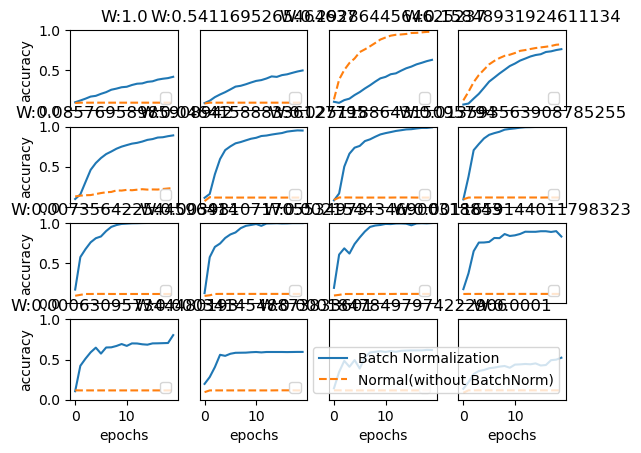

In [6]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 3.グラフの描画==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

# ch06/overfit_weight_decay.py

epoch:0, train acc:0.11666666666666667, test acc:0.1019
epoch:1, train acc:0.13333333333333333, test acc:0.1154
epoch:2, train acc:0.15, test acc:0.1339
epoch:3, train acc:0.16666666666666666, test acc:0.1544
epoch:4, train acc:0.19666666666666666, test acc:0.1714
epoch:5, train acc:0.20333333333333334, test acc:0.1888
epoch:6, train acc:0.24666666666666667, test acc:0.2075
epoch:7, train acc:0.26666666666666666, test acc:0.2218
epoch:8, train acc:0.2733333333333333, test acc:0.2377
epoch:9, train acc:0.28, test acc:0.2503
epoch:10, train acc:0.30333333333333334, test acc:0.2638
epoch:11, train acc:0.32666666666666666, test acc:0.2733
epoch:12, train acc:0.36, test acc:0.2859
epoch:13, train acc:0.36, test acc:0.2926
epoch:14, train acc:0.4, test acc:0.3058
epoch:15, train acc:0.4, test acc:0.3183
epoch:16, train acc:0.41, test acc:0.3231
epoch:17, train acc:0.42, test acc:0.3265
epoch:18, train acc:0.43333333333333335, test acc:0.3319
epoch:19, train acc:0.45, test acc:0.3426
epoch:20

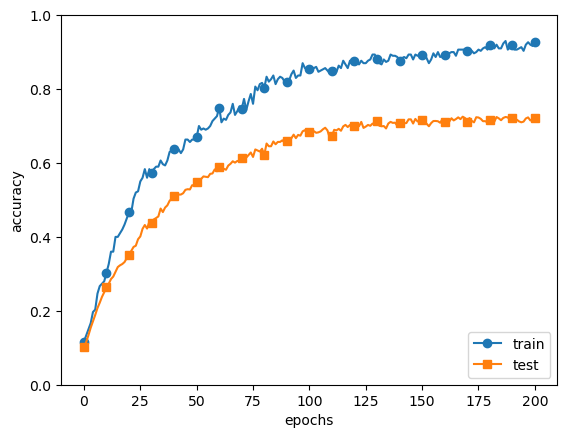

In [7]:
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
#weight_decay_lambda = 0 # weight decayを使用しない場合
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# ch06/overfit_dropout.py

train loss:2.306975946889085
=== epoch:1, train acc:0.10333333333333333, test acc:0.1049 ===
train loss:2.309044746734719
train loss:2.300197138914193
train loss:2.2899364208250144
=== epoch:2, train acc:0.10333333333333333, test acc:0.1078 ===
train loss:2.299351697213905
train loss:2.298579211918337
train loss:2.30033972809789
=== epoch:3, train acc:0.10333333333333333, test acc:0.1084 ===
train loss:2.298407722243274
train loss:2.290574548807106
train loss:2.2910548846749506
=== epoch:4, train acc:0.11333333333333333, test acc:0.1092 ===
train loss:2.300846571325947
train loss:2.291865408690855
train loss:2.290360587823036
=== epoch:5, train acc:0.11666666666666667, test acc:0.1106 ===
train loss:2.2935854359351695
train loss:2.2860466184842587
train loss:2.28443588064665
=== epoch:6, train acc:0.11333333333333333, test acc:0.1116 ===
train loss:2.2806688119504157
train loss:2.289689215478857
train loss:2.288062519098229
=== epoch:7, train acc:0.11, test acc:0.1132 ===
train loss:2.

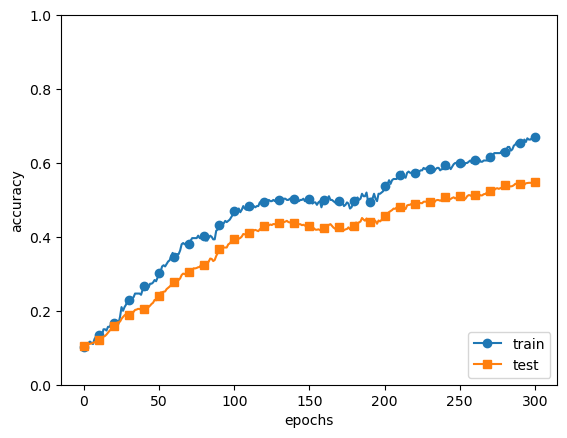

In [8]:
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuoutの有無、割り合いの設定 ========================
use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# ch06/hyperparameter_optimization.py

val acc:0.09 | lr:1.901967382287021e-06, weight decay:1.3286113794384553e-06
val acc:0.6 | lr:0.003978766790506623, weight decay:1.1494171840105422e-06
val acc:0.09 | lr:1.2638554662080983e-06, weight decay:8.29552145479523e-08
val acc:0.08 | lr:1.3645665298970673e-05, weight decay:1.6348890260392733e-06
val acc:0.1 | lr:3.376169708502469e-05, weight decay:3.6223566248485454e-06
val acc:0.2 | lr:1.054115233579305e-06, weight decay:3.6523741352877204e-06
val acc:0.09 | lr:9.484682533482772e-06, weight decay:2.7166203905198513e-08
val acc:0.19 | lr:0.0012822359991881067, weight decay:5.5083019157860015e-08
val acc:0.09 | lr:2.197396063265889e-06, weight decay:2.6199327374116732e-05
val acc:0.28 | lr:0.0028134935952994398, weight decay:9.173386087093646e-08
val acc:0.05 | lr:1.0887322819354457e-05, weight decay:5.562455484096854e-07
val acc:0.14 | lr:3.001538610842652e-05, weight decay:1.1534438081090565e-08
val acc:0.13 | lr:4.919737600309615e-06, weight decay:3.5831659974137977e-06
val 

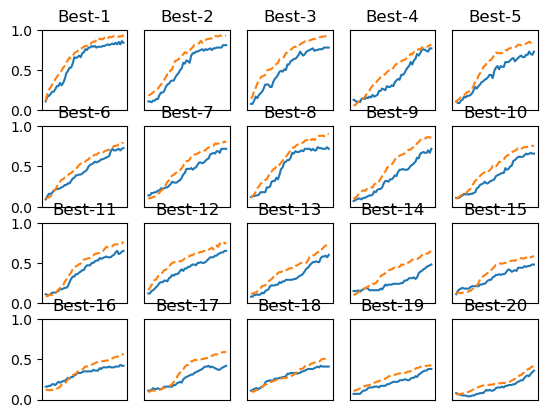

In [9]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索したハイパーパラメータの範囲を指定===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()